<a href="https://colab.research.google.com/github/Sultan0701/An-Application-of-Deep-Reinforcement-Learning-to-Algorithmic-Trading/blob/main/stock_stable_baseline_3333.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock NeurIPS2018 Part 1. Data
This series is a reproduction of paper *the process in the paper Practical Deep Reinforcement Learning Approach for Stock Trading*.

This is the first part of the NeurIPS2018 series, introducing how to use FinRL to fetch and process data that we need for ML/RL trading.

Other demos can be found at the repo of [FinRL-Tutorials]((https://github.com/AI4Finance-Foundation/FinRL-Tutorials)).

# Part 1. Install Packages

In [1]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
!pip install stable-baselines3
!pip install --upgrade numpy

## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-av94f0y1
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-av94f0y1
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit ac304347b2a43afc3b08cab0b15d04e7c22f8afd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-1rya90pp/elegantrl_b1bb0d80eaa841f39819aa4216871f08
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-1rya90pp/elegantrl_b1bb0d80eaa841f39819aa4216871f08
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit b4b9d662b9f9cb7cc368ac2b1036b5119eb20be4
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS

import itertools

# Part 2. Fetch data

[yfinance](https://github.com/ranaroussi/yfinance) is an open-source library that provides APIs fetching historical data form Yahoo Finance. In FinRL, we have a class called [YahooDownloader](https://github.com/AI4Finance-Foundation/FinRL/blob/master/finrl/meta/preprocessor/yahoodownloader.py) that use yfinance to fetch data from Yahoo Finance.

**OHLCV**: Data downloaded are in the form of OHLCV, corresponding to **open, high, low, close, volume,** respectively. OHLCV is important because they contain most of numerical information of a stock in time series. From OHLCV, traders can get further judgement and prediction like the momentum, people's interest, market trends, etc.

## Data for a single ticker

Here we provide two ways to fetch data with single ticker, let's take Apple Inc. (AAPL) as an example.

### Using yfinance

In [6]:
aapl_df_yf = yf.download(tickers = "aapl", start='2012-01-01', end='2020-01-01')

/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [7]:
aapl_df_yf.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433825,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500644,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639426,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771559,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751300,394024400


### Using FinRL

In FinRL's YahooDownloader, we modified the data frame to the form that convenient for further data processing process. We use adjusted close price instead of close price, and add a column representing the day of a week (0-4 corresponding to Monday-Friday).

In [8]:
aapl_df_finrl = YahooDownloader(start_date = '2012-01-01',
                                end_date = '2020-01-01',
                                ticker_list = ['aapl']).fetch_data()

/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (2012, 8)


In [9]:
aapl_df_finrl.head()

,date,open,high,low,close,volume,tic,day
0,2012-01-03,14.621429,14.732143,14.607143,12.433825,302220800,aapl,1
1,2012-01-04,14.642857,14.810000,14.617143,12.500644,260022000,aapl,2
2,2012-01-05,14.819643,14.948214,14.738214,12.639426,271269600,aapl,3
3,2012-01-06,14.991786,15.098214,14.972143,12.771559,318292800,aapl,4
4,2012-01-09,15.196429,15.276786,15.048214,12.751300,394024400,aapl,0


## Data for the chosen tickers

In [10]:
config_tickers.DOW_30_TICKER

['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [11]:
TRAIN_START_DATE = '2012-01-01'
TRAIN_END_DATE = '2018-01-01'
TRADE_START_DATE = '2018-01-01'
TRADE_END_DATE = '2020-01-01'

In [12]:
df_raw = YahooDownloader(start_date=TRAIN_START_DATE,
                         end_date=TRADE_END_DATE,
                          ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 co

Shape of DataFrame:  (58547, 8)


In [13]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2012-01-03,14.621429,14.732143,14.607143,12.433825,302220800,AAPL,1
1,2012-01-03,64.949997,65.190002,63.450001,46.929920,10216800,AMGN,1
2,2012-01-03,48.299999,48.959999,48.139999,40.600060,6955400,AXP,1
3,2012-01-03,74.699997,75.000000,74.120003,60.731102,6859300,BA,1
4,2012-01-03,92.769997,95.110001,92.769997,67.639664,8177000,CAT,1


# Part 3: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

Hear let's take **MACD** as an example. Moving average convergence/divergence (MACD) is one of the most commonly used indicator showing bull and bear market. Its calculation is based on EMA (Exponential Moving Average indicator, measuring trend direction over a period of time.)

In [14]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (2011, 8)


Successfully added vix
Successfully added turbulence index


In [15]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [16]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2012-01-03,AAPL,14.621429,14.732143,14.607143,12.433825,302220800.0,1.0,0.0,12.56173,12.372739,100.0,66.666667,100.0,12.433825,12.433825,22.969999,0.0
1,2012-01-03,AMGN,64.949997,65.190002,63.450001,46.929920,10216800.0,1.0,0.0,12.56173,12.372739,100.0,66.666667,100.0,46.929920,46.929920,22.969999,0.0
2,2012-01-03,AXP,48.299999,48.959999,48.139999,40.600060,6955400.0,1.0,0.0,12.56173,12.372739,100.0,66.666667,100.0,40.600060,40.600060,22.969999,0.0
3,2012-01-03,BA,74.699997,75.000000,74.120003,60.731102,6859300.0,1.0,0.0,12.56173,12.372739,100.0,66.666667,100.0,60.731102,60.731102,22.969999,0.0
4,2012-01-03,CAT,92.769997,95.110001,92.769997,67.639664,8177000.0,1.0,0.0,12.56173,12.372739,100.0,66.666667,100.0,67.639664,67.639664,22.969999,0.0


# Part 4: Save the Data

### Split the data for training and trading

In [17]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

43761
14558


### Save data to csv file

For Colab users, you can open the virtual directory in colab and manually download the files.

For users running on your local environment, the csv files should be at the same directory of this notebook.

In [18]:
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

### *Stock NeurIPS2018 Part 2. Train*
This series is a reproduction of the process in the paper Practical Deep Reinforcement Learning Approach for Stock Trading.

This is the second part of the NeurIPS2018 series, introducing how to use FinRL to make data into the gym form environment, and train DRL agents on it.

Other demos can be found at the repo of FinRL-Tutorials.


In [19]:
import finrl

In [20]:
import os
import pandas as pd

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR

check_and_make_directories([TRAINED_MODEL_DIR])

In [21]:
train = pd.read_csv('train_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure
# it has the columns and index in the form that could be make into the environment.
# Then you can comment and skip the following two lines.
train = train.set_index(train.columns[0])
train.index.names = ['']

In [22]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [23]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [24]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [25]:
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

In [26]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [27]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=30000) if if_using_a2c else None

-------------------------------------
| time/                 |           |
|    fps                | 94        |
|    iterations         | 100       |
|    time_elapsed       | 5         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0.027     |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 44.3      |
|    reward             | 0.5041327 |
|    std                | 1         |
|    value_loss         | 1.72      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 107      |
|    iterations         | 200      |
|    time_elapsed       | 9        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -41.3    |
|    explained_variance | -0.0454  |
|    learning_rate      | 0.0007   |
|    n_updates        

In [82]:
trained_a2c



In [28]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

In [29]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [30]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=100000) if if_using_ppo else None


------------------------------------
| time/              |             |
|    fps             | 125         |
|    iterations      | 1           |
|    time_elapsed    | 16          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.08289186 |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 2           |
|    time_elapsed         | 31          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015842956 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.0325      |
|    learning_rate        | 0.00025     |
|    loss                 | 2.04        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0292  

In [31]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

In [32]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

%matplotlib inline
from finrl.config import INDICATORS

In [33]:
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure
# it has the columns and index in the form that could be make into the environment.
# Then you can comment and skip the following lines.
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [34]:
if_using_a2c = True
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

In [35]:
trained_a2c = A2C.load("trained_models/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load("trained_models/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load("trained_models/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load("trained_models/agent_td3") if if_using_td3 else None
trained_sac = SAC.load("trained_models/agent_sac") if if_using_sac else None

In [36]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [37]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [38]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [39]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [40]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [41]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else (None, None)

In [42]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym) if if_using_td3 else (None, None)

In [43]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym) if if_using_sac else (None, None)

#
Part 3: Mean Variance Optimization



In [44]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

In [45]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

#Calculate the weights for mean-variance

In [46]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[ 40.67098618, 147.57380676,  90.50650787, ...,  39.03197479,
         58.3628006 ,  88.62324524],
       [ 40.66388702, 150.35855103,  91.06451416, ...,  38.22989655,
         58.79888153,  89.39629364],
       [ 40.8527832 , 149.72488403,  92.57918549, ...,  38.35385132,
         55.75419998,  89.47720337],
       ...,
       [ 70.51991272, 213.92417908, 118.09741211, ...,  48.79304504,
         48.4459343 , 112.2149353 ],
       [ 70.49315643, 213.59695435, 117.8902359 , ...,  48.98410034,
         48.54463196, 112.28065491],
       [ 70.91152954, 212.48268127, 117.05213928, ...,  48.72935867,
         48.45415497, 112.10227966]])

In [47]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)


#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)


Mean returns of assets in k-portfolio 1
 [0.09  0.086 0.061 0.11  0.057 0.112 0.069 0.031 0.081 0.081 0.114 0.082
 0.005 0.064 0.065 0.094 0.034 0.053 0.083 0.046 0.097 0.078 0.038 0.069
 0.111 0.11  0.042 0.072 0.049]
Variance-Covariance matrix of returns
 [[2.457 0.592 0.48  0.592 0.693 0.804 0.629 0.476 0.481 0.689 0.487 0.586
  0.477 0.683 0.284 0.616 0.286 0.375 0.465 0.336 0.725 0.492 0.301 0.339
  0.51  0.595 0.264 0.531 0.291]
 [0.592 2.227 0.689 0.651 0.628 0.937 0.58  0.543 0.651 0.86  0.624 0.718
  0.483 0.679 0.649 0.825 0.362 0.407 0.557 0.821 0.628 0.594 0.449 0.512
  0.743 0.769 0.419 0.786 0.39 ]
 [0.48  0.689 1.514 0.63  0.705 0.758 0.513 0.52  0.565 0.945 0.54  0.663
  0.468 0.592 0.385 0.901 0.328 0.302 0.511 0.455 0.582 0.574 0.3   0.449
  0.516 0.744 0.345 0.496 0.292]
 [0.592 0.651 0.63  1.675 0.783 0.736 0.571 0.58  0.61  0.844 0.515 0.771
  0.543 0.63  0.408 0.778 0.369 0.376 0.598 0.457 0.571 0.547 0.338 0.481
  0.516 0.647 0.367 0.558 0.316]
 [0.693 0.628 0.70

# Use PyPortfolioOpt

In [48]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([ 17330.,      0.,      0., 166910.,      0.,   5800.,      0.,
            0.,      0.,      0., 361930.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,  41020.,      0.,  41810.,
            0.,      0.,      0., 224810., 140380.,      0.,      0.,
            0.])

In [49]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([ 433.732,    0.   ,    0.   ,  593.886,    0.   ,   56.735,
          0.   ,    0.   ,    0.   ,    0.   , 2208.715,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
        218.767,    0.   ,  523.631,    0.   ,    0.   ,    0.   ,
       1113.668, 1284.777,    0.   ,    0.   ,    0.   ])

In [83]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Part 4: DJIA index

In [84]:
TRAIN_START_DATE = '2012-01-01'
TRAIN_END_DATE = '2020-01-01'
TRADE_START_DATE = '2018-01-01'
TRADE_END_DATE = '2020-01-01'

In [85]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['dji']).fetch_data()
# df_dji

/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (355, 8)


In [86]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')
# dji

In [90]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)

result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

<ipython-input-90-53b384e80df0>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


In [91]:
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('djia')
result.columns = col_name

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

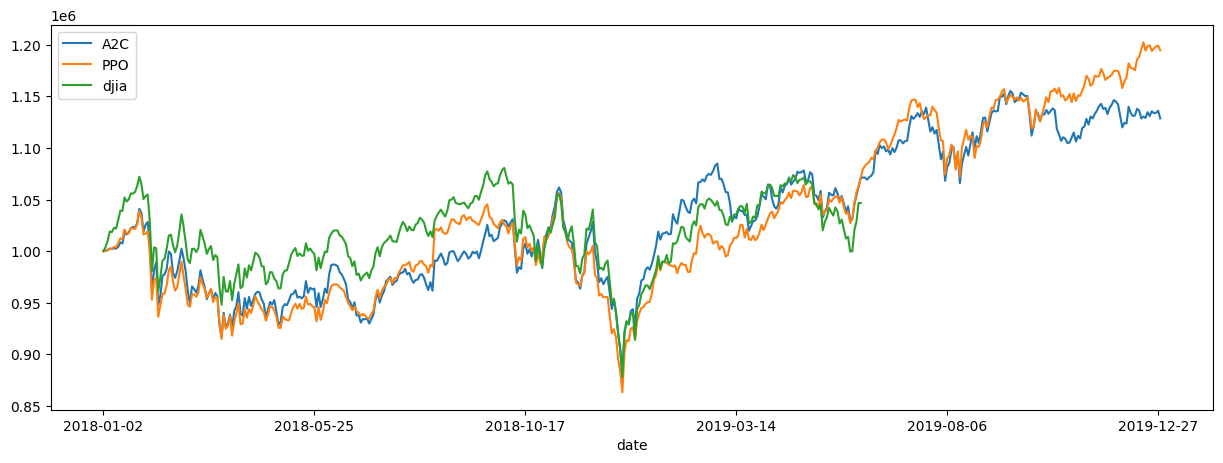

In [92]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()